In [85]:
import numpy as np

X = np.array([[2.5, 2.4],
              [0.5, 0.7],
              [2.2, 2.9],
              [1.9, 2.2],
              [3.1, 3.0],
              [2.3, 2.7],
              [2, 1.6],
              [1, 1.1],
              [1.5, 1.6],
              [1.1, 0.9]])

# SVD分解

$$ 
M = U \Sigma V^T \\
MM^T = U\Sigma V^T V \Sigma^T U^T \\
MM^T = U \Sigma \Sigma^T U^T \\
MM^TU = U\Sigma\Sigma^T
$$

设 $\Lambda = \Sigma\Sigma^T$, 由此可得，U矩阵是$MM^T$的特征向量，特征值是$\Lambda$

$$ 
M = U \Sigma V^T \\
M^TM = V\Sigma^TU^T U\Sigma V^T \\
M^TM = V\Sigma^T\Sigma V^T \\
M^TMV = V\Sigma^T\Sigma
$$

其中，由于$\Sigma$是对角矩阵，对称矩阵，因此$\Sigma^T\Sigma = \Sigma\Sigma^T = \Lambda$

由此可得，V矩阵是$M^TM$的特征向量，特征值是$\Lambda$

In [86]:
def svd(M: np.ndarray):
    """
    手动实现 SVD 分解
    - U 是 M @ M^T 的特征向量
    - V 是 M^T @ M 的特征向量
    - S 是奇异值，按照降序排列
    """
    # 计算 M @ M^T 和 M^T @ M 的特征值和特征向量
    MMT = M @ M.T
    MTM = M.T @ M

    # 计算特征值和特征向量
    LAMBDA_U, U = np.linalg.eigh(MMT) #np.linalg.eigh得到的特征值不是SVD需要是降序排列
    LAMBDA_V, V = np.linalg.eigh(MTM)

    # 对奇异值进行降序排列
    sorted_indices = np.argsort(-LAMBDA_U)  # 按降序排列
    U = U[:, sorted_indices]

    # V 需要按照相同的顺序调整
    sorted_indices_V = np.argsort(-LAMBDA_V)
    V = V[:, sorted_indices_V]

    # 计算奇异值
    if len(LAMBDA_V) < len(LAMBDA_U):
        S = np.sqrt(LAMBDA_V[sorted_indices_V])
    else:
        S = np.sqrt(LAMBDA_U[sorted_indices])

    # 修正符号：调整 `U` 和 `V` 的列符号，使结果一致
    for i in range(len(S)):
        if np.sign(U[0, i]) != np.sign(V[0, i]):
            V[:, i] *= -1

    return U, S, V.T


In [87]:
# 计算 SVD
U, S, Vt = svd(X)
print(U.shape, S.shape, Vt.shape)
# 输出结果
print("U 矩阵：")
print(U[:2, :2])
print("\n奇异值：")
print(S)
print("\nV 转置矩阵：")
print(Vt)

(10, 10) (2,) (2, 2)
U 矩阵：
[[-0.38507927  0.25575629]
 [-0.09481302 -0.17561812]]

奇异值：
[8.98868529 0.66598554]

V 转置矩阵：
[[-0.68647784 -0.72715072]
 [ 0.72715072 -0.68647784]]


In [88]:
# 可以复现原来的值
U[:,:2] @ np.diag(S) @ Vt

array([[2.5, 2.4],
       [0.5, 0.7],
       [2.2, 2.9],
       [1.9, 2.2],
       [3.1, 3. ],
       [2.3, 2.7],
       [2. , 1.6],
       [1. , 1.1],
       [1.5, 1.6],
       [1.1, 0.9]])

### 对比调包的结果

对比发现，结果一致

In [89]:
# 计算 SVD
U, S, Vt = np.linalg.svd(X)
print(U.shape, S.shape, Vt.shape)
# 输出结果
print("U 矩阵：")
print(U[:2, :2])
print("\n奇异值：")
print(S)
print("\nV 转置矩阵：")
print(Vt)

(10, 10) (2,) (2, 2)
U 矩阵：
[[-0.38507927  0.25575629]
 [-0.09481302 -0.17561812]]

奇异值：
[8.98868529 0.66598554]

V 转置矩阵：
[[-0.68647784 -0.72715072]
 [ 0.72715072 -0.68647784]]


# PCA

PCA的过程主要分两步
1. 去中心化
2. 通过协方差矩阵计算R矩阵

关于第二个步骤：

说明：$X_i$是一个行向量，确保数据矩阵的每一列是一个特征，每一行是一个样本。

$cov(X) = \frac{1}{n-1} X^TX$

R矩阵就是cov(X)的特征向量，解释方差就是cov(X)的特征值

由上面已知：V是$X^TX$的特征向量，$\Lambda$是$X^TX$的特征值。

所以，R就是SVD中的V，解释方差就是$\frac{\Sigma^T \Sigma}{n-1}$,其中n是样本数量。

In [90]:
def pca(X, n_components):

    # 去中心化
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    # 计算旋转矩阵
    U, S, Vt = svd(X_centered)

    # 确保符号一致，调整 U 和 Vt 的符号
    for i in range(n_components):
        if np.sum(U[:, i]) < 0:
            U[:, i] = -U[:, i]
            Vt[i, :] = -Vt[i, :]

    # 旋转矩阵R就是V
    R = Vt.T[:, :n_components]

    # 计算解释方差
    explained_variance = S**2 / (len(X) - 1)

    # 数据投影到新空间
    X_pca = X_centered @ R

    return X_pca, R, explained_variance

    

In [91]:
# 执行 PCA
n_components = 2  # 降维到 2 个主成分
X_pca, components, explained_variance = pca(X, n_components)

# 输出结果
print("降维后的数据：")
print(X_pca)
print("\n主成分方向：")
print(components)
print("\n解释方差：")
print(explained_variance)

降维后的数据：
[[ 0.82797019 -0.17511531]
 [-1.77758033  0.14285723]
 [ 0.99219749  0.38437499]
 [ 0.27421042  0.13041721]
 [ 1.67580142 -0.20949846]
 [ 0.9129491   0.17528244]
 [-0.09910944 -0.3498247 ]
 [-1.14457216  0.04641726]
 [-0.43804614  0.01776463]
 [-1.22382056 -0.16267529]]

主成分方向：
[[ 0.6778734  -0.73517866]
 [ 0.73517866  0.6778734 ]]

解释方差：
[1.28402771 0.0490834 ]


### 对比调包的结果

对比发现，结果一致

In [92]:
from sklearn.decomposition import PCA

# 创建 PCA 模型，指定目标维度
n_components = 2
pca = PCA(n_components=n_components)

# 拟合数据并进行降维
X_pca = pca.fit_transform(X)

# 输出结果
print("降维后的数据：")
print(X_pca)
print("\n主成分方向：")
print(pca.components_)  # 每一行是一个主成分方向向量
print("\n解释方差：")
print(pca.explained_variance_)


降维后的数据：
[[ 0.82797019  0.17511531]
 [-1.77758033 -0.14285723]
 [ 0.99219749 -0.38437499]
 [ 0.27421042 -0.13041721]
 [ 1.67580142  0.20949846]
 [ 0.9129491  -0.17528244]
 [-0.09910944  0.3498247 ]
 [-1.14457216 -0.04641726]
 [-0.43804614 -0.01776463]
 [-1.22382056  0.16267529]]

主成分方向：
[[ 0.6778734   0.73517866]
 [ 0.73517866 -0.6778734 ]]

解释方差：
[1.28402771 0.0490834 ]


# KPCA(基于核函数的主成分分析)

PCA的本质是在各个正交方向上将数据解除线性相关，但是高阶相关性就无法解除了。

对于存在高阶相关性的数据，应使用基于核函数的主成分分析方法。该方法通过核函数将非线性相关转换为线性相关。

对于线性不可分的数据集 $\{ x\}$, 可以利用函数 $\phi(x)$将其映射到高维上后再划分。

对于n个观测值的映射为：

$$X = [\phi(x_1),\phi(x_2),\dots, \phi(x_n)]^T 
= \left( \begin{array}{c} \phi(x_1)^T \\ \phi(x_2)^T \\ \vdots \\ \phi(x_n)^T \end{array} \right)$$

因此，他的协方差矩阵为：

$$
\Sigma = \frac{1}{n-1}X^TX 
= \frac{1}{n-1}[\phi(x_1),\phi(x_2),\dots, \phi(x_n)]\left( \begin{array}{c} \phi(x_1)^T \\ \phi(x_2)^T \\ \vdots \\ \phi(x_n)^T \end{array} \right)
$$

但是因为函数 $\phi(x)$是未知的，因此无法得到该协方差矩阵的特征值和特征向量。

因此，引入核函数 $k(x_i, x_j)$来构造矩阵：

$$
k = XX^T = \left( \begin{array}{c} \phi(x_1)^T \\ \phi(x_2)^T \\ \vdots \\ \phi(x_n)^T \end{array} \right)[\phi(x_1),\phi(x_2),\dots, \phi(x_n)]

= K = \begin{bmatrix}
k(x_1, x_1) & k(x_1, x_2) & \cdots & k(x_1, x_n) \\
k(x_2, x_1) & k(x_2, x_2) & \cdots & k(x_2, x_n) \\
\vdots & \vdots & \ddots & \vdots \\
k(x_n, x_1) & k(x_n, x_2) & \cdots & k(x_n, x_n)
\end{bmatrix}
$$

核函数矩阵K的特征方程为：
$$Ku=(XX^T)u=\lambda u$$

对核矩阵 $K $ 进行特征值分解：  
$$
K = U \Lambda U^T
$$
- $U \in \mathbb{R}^{n \times n}$：特征向量组成的正交矩阵，列向量为 $K$ 的特征向量。
- $\Lambda \in \mathbb{R}^{n \times n}$：对角矩阵，其对角元素为核矩阵的特征值。

- 特征向量矩阵 $U $ 满足正交性：  
    $$
    U^T U = I
    $$
    其中 $I $ 是 $n \times n$ 的单位矩阵。


将特征方程左乘 $X^T$, 得到：

$$ X^T(XX^T)u = X^T\lambda u$$

因此：

$$X^TX(X^Tu) = \lambda (X^T u)$$

因此，协方差矩阵 $\Sigma$ 的特征向量为 $X^T u$

将协方差矩阵 $\Sigma$ 的特征向量为 $X^T u$归一化：

$$
v = \frac{1}{\|X^Tu\|} X^Tu = \frac{1}{\sqrt{u^TXX^Tu}}X^Tu = \frac{1}{\sqrt{u^TKu}}X^Tu
= \frac{1}{\sqrt{u^T\lambda u}} X^Tu = \frac{1}{\sqrt{\lambda}} X^Tu
$$

但是我们无法得到这个特征向量v，因为我们并不知道通过 $\phi(x)$ 计算得来的X

但是我们可以计算观测量在单位特征向量v特征向量的投影，也就是 $\lambda$ 的主成分。

$$
Y^T = V^T X^T = (\frac{1}{\sqrt{\lambda}} X^TU)^T X^T
= \frac{1}{\sqrt{\lambda}} U^T X X^T
= \frac{1}{\sqrt{\lambda}} U^T K UU^{-1}
= \frac{1}{\sqrt{\lambda}} U^T \lambda UU^T
= \frac{\lambda}{\sqrt{\lambda}} (U^TU)U^T
= \sqrt{\lambda} U^T
$$


## 特征空间的中心化

我们在做PCA的时候，第一步是需要对数据去中心化。

在kpca中，我们是需要对特征空间数据 $\phi(x)$ 进行归一化，而不是核函数矩阵K作归一化。

因此, 下面这样的写法是错误的。
```python
mean_k = np.mean(k, axis=0)
k_centered = k - mean_k
```

**正确中心化公式的几何含义**

如果要让特征空间中的点真正居中（均值为零），就需要确保：
$$
\frac{1}{N} \sum_{i=1}^N \phi(\mathbf{x}_i) = 0
$$

这等价于调整核矩阵 $ K $，使得调整后的核矩阵 $ K_{\text{centered}} $ 仍然表示特征空间中点之间的内积关系，但在居中的新坐标系下：
$$
K_{\text{centered},ij} = \langle \phi_{\text{centered}}(\mathbf{x}_i), \phi_{\text{centered}}(\mathbf{x}_j) \rangle
$$
其中 $\phi_{\text{centered}}(\mathbf{x}_i) = \phi(\mathbf{x}_i) - \frac{1}{N} \sum_{j=1}^N \phi(\mathbf{x}_j)$。  

对应的公式推导为：
$$
K_{\text{centered}} = K - \mathbf{1}_N K - K \mathbf{1}_N + \mathbf{1}_N K \mathbf{1}_N
$$
这一步考虑了核矩阵中的点对关系，是从高维特征空间的几何性质出发的，确保点与点之间的内积关系在居中操作后仍然正确。

In [18]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


# 生成moons数据集
X, y = make_moons(n_samples=100, random_state=123)

def draw(X, X_kpca, lin_svc=None):
    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.title("original data")

    plt.subplot(1, 2, 2)
    plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.title("KPCA")
    if lin_svc:
        # 绘制SVM的决策边界
        w = lin_svc.coef_
        a = -w[0][0] / w[0][1]
        xx = np.linspace(min(X_kpca[:, 0]), max(X_kpca[:, 0]))
        yy = a * xx - (lin_svc.intercept_[0]) / w[0][1]

        # 在KPCA的图上绘制决策边界
        plt.plot(xx, yy, 'k-')
        plt.ylim(-0.4, 0.4)
    plt.show()



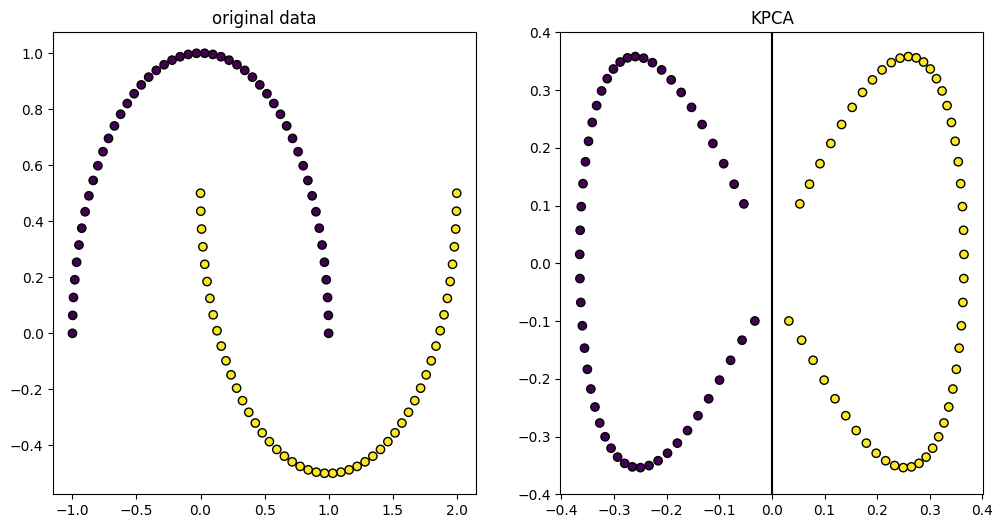

In [2]:
# 使用KPCA进行降维
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)
 
# 使用线性支持向量机进行分类
lin_svc = LinearSVC()
lin_svc.fit(X_kpca, y)
draw(X, X_kpca, lin_svc)


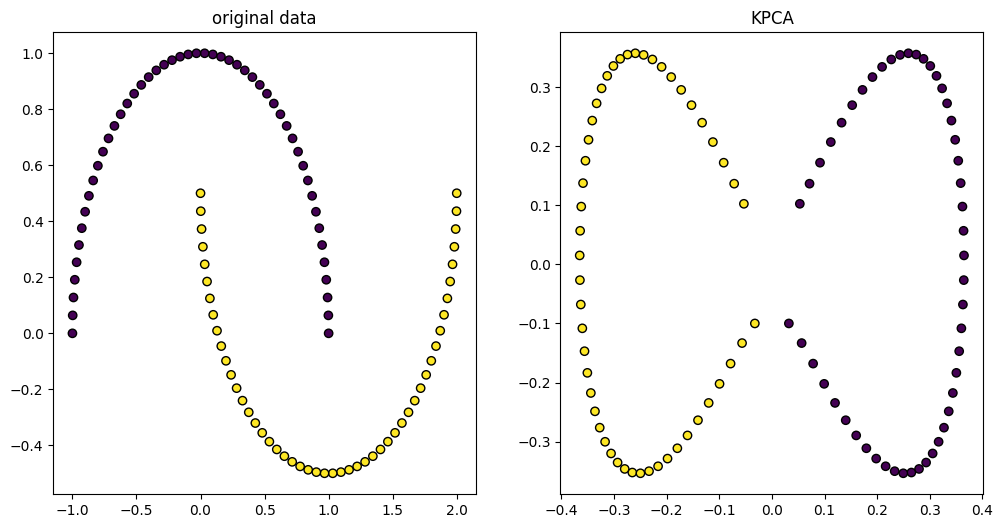

In [ ]:
class MY_KPCA:
    
    def __init__(self, n_components=2, kernel='rbf', **kernel_params):
        self.n_components = n_components
        self.kernel = kernel
        self.kernel_params = kernel_params

        if self.kernel == "rbf":
            self.kernel_func = self.__gaussian_kernel
        elif self.kernel == "linear":
            self.kernel_func = self.__linear_kernel
        elif self.kernel == "poly":
            self.kernel_func = self.__poly_kernel
    
    def fit(self, data):
        k = self.kernel_func(data, data, **self.kernel_params)

        # 而是这样中心化
        N = k.shape[0]
        one_n = np.ones((N, N)) / N # 由于one_n 部分除以了N，所以矩阵相乘相当于求的均值。
        k_centered = k - one_n @ k - k @ one_n + one_n @ k @ one_n

        # 求特征值
        # Step 3: 对中心化的核矩阵进行特征值分解
        eigvals, eigvecs = np.linalg.eigh(k_centered)

        # 取前几个特征值
        eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
        alphas = eigvecs[:, :self.n_components]
        lambdas = eigvals[:self.n_components]

        return alphas * np.sqrt(lambdas), lambdas

    def __gaussian_kernel(self, x, y, gamma=15):
        #np.sum(x**2, axis=1)[:, None] + np.sum(y**2, axis=1) 利用广播机制，结果的shape是[100, 100]
        mse = np.sum(x**2, axis=1)[:, None] + np.sum(y**2, axis=1) - 2 * np.dot(x, y.T) #x.shape [100, 2]
        return np.exp(-gamma * mse)
    
    def __linear_kernel(self, x, y): # kpca用线性核，结果和pca一致
        return x @ y.T
    
    def __poly_kernel(self, x, y, a=1, c=2, d=4):
        return np.power(a * (x @ y.T) + c, d)
        

my_kpca = MY_KPCA(n_components=2, kernel='rbf', gamma=15)
# my_kpca = MY_KPCA(n_components=2, kernel='poly', d=3, c=1, a=100)
X_kpca, lambdas = my_kpca.fit(X)
draw(X, X_kpca)